In [1]:
from models import custom_RF as cm
from load_dataset import custom_lakedepth as ld
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]
from pprint import pprint

In [2]:
lake_depth_data = ld.LakeDepth(random_state = 42)

# Only take first 6 bands
adjusted_columns_idx = lake_depth_data.covariates.columns[:6]
lake_depth_data.covariates = lake_depth_data.covariates[adjusted_columns_idx]
covariates_train, covariates_test, labels_train, labels_test = lake_depth_data.split(0.20)

# Make sure we did it right
lake_depth_data.covariates.head(5)

 - from DATA: reading csv into GPU memory
 - from DATA: done reading csv into GPU memory
 - from DATA: dropped column: FID
 - from DATA: dropped column: Date


,b1_LC8_075,b2_LC8_075,b3_LC8_075,b4_LC8_075,b5_LC8_075,b6_LC8_075
0,164.0,271.0,199.0,42.0,27.0,16.0
1,165.0,272.0,196.0,44.0,29.0,16.0
2,154.0,260.0,193.0,40.0,32.0,19.0
3,156.0,250.0,195.0,48.0,40.0,26.0
4,117.0,164.0,78.0,38.0,23.0,17.0


In [3]:
# Params for our fancy GPU-based RF model
hyperparameters = {'N_ESTIMATORS' : 1052,
					   'SPLIT_ALGO' : 1,
					   'SPLIT_CRITERION' : 2,
					   'BOOTSTRAP' : False,
					   'BOOTSTRAP_FEATURES' : False,
					   'ROWS_SAMPLE' : 1.0,
					   'MAX_DEPTH' : 50,
					   'MAX_LEAVES' : -1,
					   'MAX_FEATURES' : 'sqrt',
					   'N_BINS' : 16,
					   'MIN_ROWS_PER_NODE' : 2,
					   'MIN_IMPURITY_DECREASE' : 0.0,
					   'ACCURACY_METRIC' : 'mean_ae', # 'mse' #'r2' # 'median_aw' # 
					   'QUANTILEPT' : False,
					   'SEED' :  42,
					   'VERBOSE' : False
					   }
pprint(hyperparameters)

{'ACCURACY_METRIC': 'mean_ae',
 'BOOTSTRAP': False,
 'BOOTSTRAP_FEATURES': False,
 'MAX_DEPTH': 50,
 'MAX_FEATURES': 'sqrt',
 'MAX_LEAVES': -1,
 'MIN_IMPURITY_DECREASE': 0.0,
 'MIN_ROWS_PER_NODE': 2,
 'N_BINS': 16,
 'N_ESTIMATORS': 1052,
 'QUANTILEPT': False,
 'ROWS_SAMPLE': 1.0,
 'SEED': 42,
 'SPLIT_ALGO': 1,
 'SPLIT_CRITERION': 2,
 'VERBOSE': False}


In [4]:
import time
rf_model_bands_one_six = cm.cuRF(hyperparameters)
st = time.time()
rf_model_bands_one_six.train(covariates_train, labels_train)
et = time.time()
print("Time to train: ", et-st)

/att/gpfsfs/briskfs01/ppl/cssprad1/projects/rapids_rf_lake_depth/models/custom_RF.py:154: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams==1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  verbose=param['VERBOSE'])


Time to train:  6.295085191726685


In [5]:
predictions, _, _, _ = rf_model_bands_one_six.get_metrics(covariates_test, labels_test)

Scores ------
 MAE:  0.563588
  r2:  0.6421920905381562
 MSE:  1.3636352


Variables: b6_LC8_075           Importance: -0.27734
Variables: b5_LC8_075           Importance: -0.32161
Variables: b2_LC8_075           Importance: -0.39602
Variables: b4_LC8_075           Importance: -0.56455
Variables: b1_LC8_075           Importance: -0.74304
Variables: b3_LC8_075           Importance: -0.90728


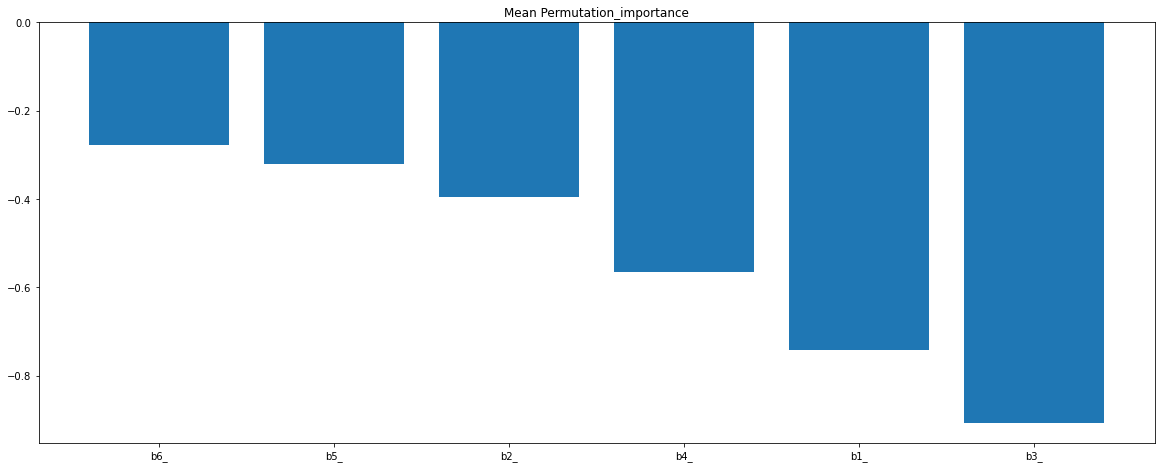

In [6]:
rf_model_bands_one_six.feature_importances(covariates_train, labels_train, show = False)

## Hard-code the permutation_importance to check for errors

In [10]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf_model_bands_one_six.model, 
                                covariates_train, 
                                labels_train, 
                                n_repeats=5, 
                                random_state=42)

Feature: 0, Score: -0.27879
Feature: 1, Score: -0.32295
Feature: 2, Score: -0.39373
Feature: 3, Score: -0.56305
Feature: 4, Score: -0.73796
Feature: 5, Score: -0.90151


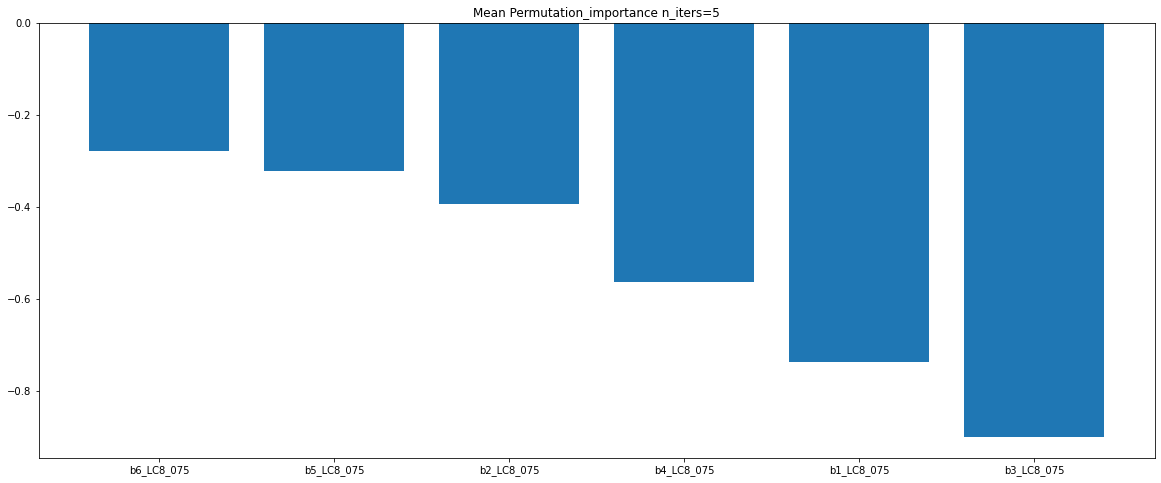

Importances_mean:  [-0.73795779 -0.3937282  -0.90150766 -0.56305225 -0.32295171 -0.27878996]
Importances_std:  [0.00768603 0.00098691 0.00635885 0.00413913 0.00305672 0.00158862]


In [21]:
import numpy as np
sorted_idx = result.importances_mean.argsort()
sorted_idx = np.flip(sorted_idx)
importance = result.importances_mean
for i, v in enumerate(importance[sorted_idx]):
    print('Feature: %0d, Score: %.5f' %(i, v))
plt.figure(figsize=(20, 8))
plt.bar([x for x in range(len(importance))], importance[sorted_idx])
plt.xticks(range(len(importance)), list(covariates_train.columns[sorted_idx]))
plt.title("Mean Permutation_importance n_iters=5")
plt.show()
print("Importances_mean: ",result.importances_mean)
print("Importances_std: ",result.importances_std)

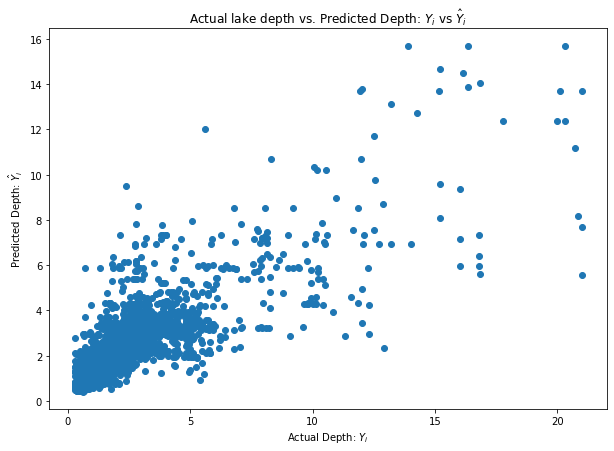

In [7]:
plt.scatter(labels_test.to_array(), predictions.to_array())
plt.xlabel("Actual Depth: $Y_i$")
plt.ylabel("Predicted Depth: $\hat{Y}_i$")
plt.title("Actual lake depth vs. Predicted Depth: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Random sampling to compare actual vs predicted values

In [8]:
# Lets look at a random sample of datapoints to see the actual vs predicted depths
import random
for i in range(20):
    random_data_point = random.randint(0, 4635)
    print('Data-point: {:5} Actual: {:20} Predicted: {:20}'.format(random_data_point, labels_test.to_array()[random_data_point],
                                               predictions.to_array()[random_data_point]))

Data-point:  2923 Actual:    1.874500036239624 Predicted:   1.3000214099884033
Data-point:   779 Actual:   1.6454700231552124 Predicted:   1.6088783740997314
Data-point:   246 Actual:   1.2772300243377686 Predicted:    1.425452470779419
Data-point:  2652 Actual:    2.314539909362793 Predicted:    2.460891008377075
Data-point:   687 Actual:   1.8826700448989868 Predicted:   2.1907904148101807
Data-point:  4390 Actual:   1.5405399799346924 Predicted:   1.4659477472305298
Data-point:  4524 Actual:    1.715250015258789 Predicted:   1.7018545866012573
Data-point:  4394 Actual:    2.182539939880371 Predicted:   2.3599331378936768
Data-point:  1404 Actual:   2.4341399669647217 Predicted:   2.3712589740753174
Data-point:  1486 Actual:    4.451920032501221 Predicted:   2.2208077907562256
Data-point:   364 Actual:    0.642857015132904 Predicted:   0.6927602291107178
Data-point:  1694 Actual:   16.338899612426758 Predicted:   15.707343101501465
Data-point:  2157 Actual:   2.8682401180267334 Predi